# Tuning Mistral
Works on ml.g5.8xlarge instance with Python 3.10 and PyTorch 2.2.0

Based on https://colab.research.google.com/github/brevdev/notebooks/blob/main/mistral-finetune-own-data.ipynb

In [3]:
!nvidia-smi

Sat Apr 20 08:56:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A10G                    Off | 00000000:00:1E.0 Off |                    0 |
|  0%   24C    P0              52W / 300W |      4MiB / 23028MiB |      4%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [4]:
#install stuff
!pip uninstall bitsandbytes transformers peft accelerate -y
!pip install bitsandbytes transformers peft accelerate
!pip install huggingface_hub
!pip install s3fs datasets
!pip install scipy ipywidgets matplotlib
!pip uninstall dotenv-python dotenv python-dotenv -y
!pip install python-dotenv
!pip install -q wandb -U #weights and biases (optional)



  Using cached bitsandbytes-0.43.1-py3-none-manylinux_2_24_x86_64.whl (119.8 MB)
  Using cached transformers-4.40.0-py3-none-any.whl (9.0 MB)
  Using cached peft-0.10.0-py3-none-any.whl (199 kB)
  Using cached accelerate-0.29.3-py3-none-any.whl (297 kB)
  Using cached torch-2.2.2-cp310-cp310-manylinux1_x86_64.whl (755.5 MB)
  Using cached tokenizers-0.19.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.6 MB)
  Using cached safetensors-0.4.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  Using cached huggingface_hub-0.22.2-py3-none-any.whl (388 kB)
  Using cached fsspec-2024.3.1-py3-none-any.whl (171 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached sympy-1.12-py3-none-any.whl (5.7 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-

In [5]:
import os
import re
import json
from datetime import datetime
from dotenv import load_dotenv, find_dotenv
import timeit


## Config

In [6]:
#load globals
_ = load_dotenv(find_dotenv(), override=True) # read local .env file
WANDB_API = os.getenv('WANDB_API')  # Get weights and biases login
HF_TOKEN = os.getenv('HF_TOKEN') #get huggingface login
DATASET_PROMPT_FIELD = 'text'
BASE_MODEL_ID = "mistralai/Mistral-7B-Instruct-v0.1"


#### Configure Accelerator

In [7]:
from accelerate import FullyShardedDataParallelPlugin, Accelerator
from torch.distributed.fsdp.fully_sharded_data_parallel import FullOptimStateDictConfig, FullStateDictConfig

fsdp_plugin = FullyShardedDataParallelPlugin(
    state_dict_config=FullStateDictConfig(offload_to_cpu=True, rank0_only=False),
    optim_state_dict_config=FullOptimStateDictConfig(offload_to_cpu=True, rank0_only=False),
)

accelerator = Accelerator(fsdp_plugin=fsdp_plugin)

Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


#### Configure Weight and Biases

In [8]:
import wandb

wandb.login(key=WANDB_API)

wandb_project = "mistral-tuning"
os.environ["WANDB_PROJECT"] = wandb_project
os.environ["WANDB_NOTEBOOK_NAME"] = "mistral-tuning-qlora"


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: danielpradilla. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


## Split datasets

In [1]:
from datasets import load_dataset

train_dataset = load_dataset('json', data_files='data/tuning_training_entries.jsonl', split='train')
eval_dataset = load_dataset('json', data_files='data/tuning_validation_entries.jsonl', split='validation')


ModuleNotFoundError: No module named 'datasets'

In [ ]:
train_dataset.shuffle().select(range(5)).map(print)

## Load Model

In [11]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from huggingface_hub import login

login(token=HF_TOKEN)
base_model_id = BASE_MODEL_ID #"mistralai/Mistral-7B-Instruct-v0.1"
#base_model_id = "python-tuning-llm/models/mistral-7b-instruct-v0.1.Q4_0" #load from local
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

model = AutoModelForCausalLM.from_pretrained(base_model_id, quantization_config=bnb_config, device_map="auto")

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.
Token is valid (permission: write).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

## Tokenization

Padding in neural networks, particularly in language models like LLaMA, is used to ensure that input sequences are all the same length for batch processing. This uniformity is crucial because it allows the model to perform operations on batches of data efficiently.

For fine-tuning a decoder-only model like LLaMA on a chat dataset, you would typically use padding at the end of the sequences. This approach, often called "post-padding," ensures that the beginning of each message (which usually contains the most relevant context) is processed first by the model. Post-padding is generally preferred in natural language processing tasks because it aligns better with how many models process sequential data, reading from the beginning to the end of a sequence.

However, For example, input: I love apple [pad] [pad]. The output of the model will contain the input and add additional output information.

For example, output: I love apple [pad] [pad],because it is delicious.

This would result in [pad] being stuck in the middle of the text. It is very bad for the model to process text. If we use left-padding, the output of this model will be

output : [pad] [pad] i love apple,because it is delicious.

By padding on the left, the model processes all the padding tokens first, which are typically ignored or masked out in the computational process, and then processes the meaningful input. This ensures that the semantic flow of the text (i.e., the actual content) is uninterrupted and continuous, leading to more coherent outputs.

Most neural network architectures, including LLMs, are sensitive to the sequence's start since they are trained to weigh initial inputs more significantly. Left-padding ensures that the meaningful part of the input is aligned closer to the point of decision-making in the model architecture, which in this case is the generation of the continuation of the text.

Source: [https://ai.stackexchange.com/questions/41485/while-fine-tuning-a-decoder-only-llm-like-llama-on-chat-dataset-what-kind-of-pa]

For model_max_length, it's helpful to get a distribution of your data lengths. Let's first tokenize without the truncation/padding, so we can get a length distribution.

In [12]:
tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    padding_side="left",
    add_eos_token=True,
    add_bos_token=True,
)
tokenizer.pad_token = tokenizer.eos_token

def tokenize_prompt(prompt):
    return tokenizer(prompt[DATASET_PROMPT_FIELD])

#reformat the prompt and tokenize each sample
tokenized_train_dataset = train_dataset.map(tokenize_prompt)
tokenized_val_dataset = eval_dataset.map(tokenize_prompt)

samples: 2678
min: 30
max: 41009
outlier limit: 1921.0


/tmp/ipykernel_17/2767001568.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_result = mode(capped_lengths)


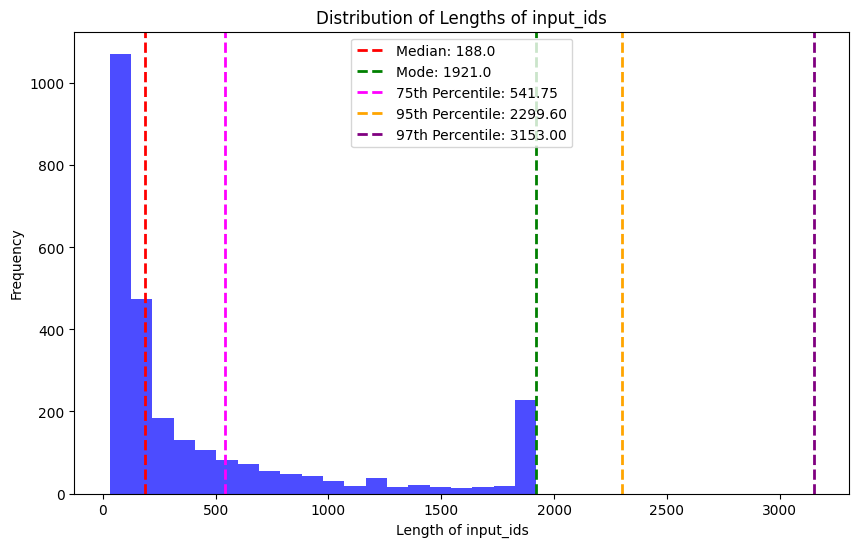

In [13]:
#inspect distribution of lengths to figure out the max_length of the input tensors

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

def plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset):
    lengths = [len(x['input_ids']) for x in tokenized_train_dataset]
    lengths += [len(x['input_ids']) for x in tokenized_val_dataset]
    print(f"samples: {len(lengths)}")
    print(f"min: {min(lengths)}")
    print(f"max: {max(lengths)}")
    
    # Calculate the 3IQR for utliers    
    outlier_limit = np.percentile(lengths, 75) + 3 * (np.percentile(lengths, 75) - np.percentile(lengths, 25))
    print(f"outlier limit: {outlier_limit}")
    capped_lengths = [min(length, outlier_limit) for length in lengths]

    # Calculate mode and median
    median_length = np.median(capped_lengths)
    try:
        mode_result = mode(capped_lengths)
        mode_length = mode_result.mode[0] if mode_result.count[0] > 0 else None
    except IndexError:
        mode_length = None

    # Calculate 95% and 99% percentiles
    percentile_75 = np.percentile(lengths, 75)
    percentile_95 = np.percentile(lengths, 95)
    percentile_97 = np.percentile(lengths, 97)
    
    # Plotting the histogram
    plt.figure(figsize=(10, 6))
    plt.hist(capped_lengths, bins=20, alpha=0.7, color='blue')
    
    #reference lines
    plt.axvline(median_length, color='red', linestyle='dashed', linewidth=2, label=f'Median: {median_length}')
    if mode_length is not None:
        plt.axvline(mode_length, color='green', linestyle='dashed', linewidth=2, label=f'Mode: {mode_length}')
    plt.axvline(percentile_75, color='magenta', linestyle='dashed', linewidth=2, label=f'75th Percentile: {percentile_75:.2f}')
    plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=2, label=f'95th Percentile: {percentile_95:.2f}')
    plt.axvline(percentile_97, color='purple', linestyle='dashed', linewidth=2, label=f'97th Percentile: {percentile_97:.2f}')
        
    plt.xlabel('Length of input_ids')
    plt.ylabel('Frequency')
    plt.title('Distribution of Lengths of input_ids')
    plt.legend()
    plt.show()

plot_data_lengths(tokenized_train_dataset, tokenized_val_dataset)

Low max_length: loss of contextual information, only the initial part of long texts is retained. Truncation bias: underrepresentation of longer documents. Reduced model performance if it's too low

Large max_length: hitting model constraints on length, impact on performance

In [14]:
#re-tokenize now that i know the lengths
max_length = 542
def tokenize_prompt2(prompt):
    result = tokenizer(
        text = prompt[DATASET_PROMPT_FIELD],
        truncation=True,
        max_length=max_length,
        padding="max_length",
    )
    result["labels"] = result["input_ids"].copy()
    return result

tokenized_train_dataset2 = train_dataset.map(tokenize_prompt2)
tokenized_val_dataset2 = eval_dataset.map(tokenize_prompt2)

In [15]:
print(tokenized_train_dataset[1]['input_ids'])

[1, 1, 733, 16289, 28793, 28749, 11666, 1849, 7142, 1540, 340, 890, 3756, 1959, 8103, 1921, 1061, 13447, 23396, 28705, 28770, 28770, 11048, 28792, 28748, 16289, 28793, 1618, 22441, 28324, 28709, 340, 3118, 543, 289, 434, 3428, 363, 2374, 488, 515, 936, 520, 389, 23199, 28725, 4777, 21186, 519, 3594, 3118, 2144, 415, 334, 482, 14546, 497, 28706, 5799, 1452, 379, 8854, 656, 10704, 337, 261, 5388, 497, 269, 639, 936, 381, 2995, 5326, 340, 365, 28733, 28782, 28750, 28713, 28723, 13, 13, 5173, 9928, 28725, 2914, 412, 8534, 383, 1711, 28725, 11176, 305, 2004, 28709, 340, 319, 3583, 385, 28725, 1037, 521, 20962, 2646, 1201, 21010, 1452, 28725, 708, 12811, 1452, 28723, 10677, 3118, 390, 8322, 481, 26756, 298, 574, 2187, 11402, 28747, 13, 28792, 11203, 28747, 2872, 1508, 2849, 28723, 450, 783, 28734, 28734, 28740, 28723, 675, 28748, 9660, 28748, 10323, 28729, 2298, 28748, 20246, 28723, 1447, 28770, 28793, 13, 13, 1976, 28742, 267, 272, 2746, 13, 6087, 613, 28742, 333, 750, 4999, 288, 302, 13, 1

samples: 2678
min: 542
max: 542
outlier limit: 542.0


/tmp/ipykernel_17/2767001568.py:22: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_result = mode(capped_lengths)


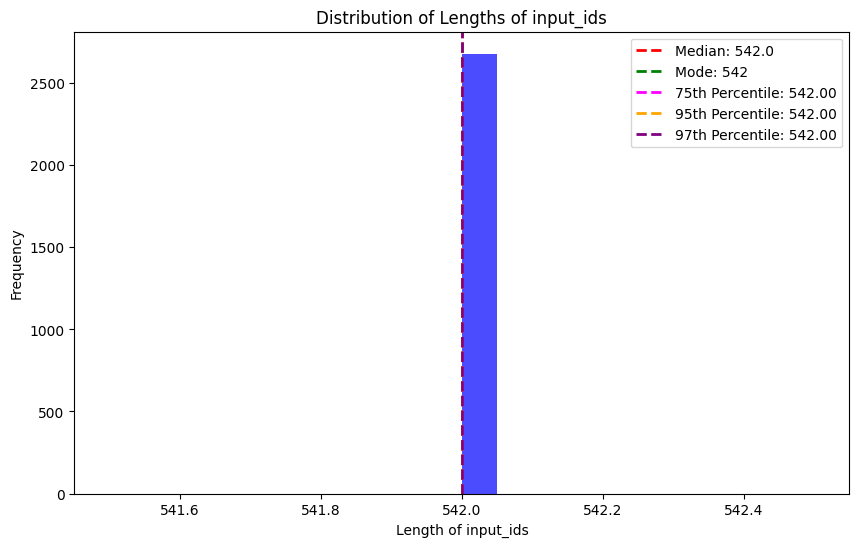

In [16]:
plot_data_lengths(tokenized_train_dataset2, tokenized_val_dataset2)

## Test model out of the box

In [17]:
eval_prompt = """<s>[INST]Given the following biometric data, score the users' health, from 0-100.

### Biometric Data:
Temperature=98.2,
Sex=F,
Age=29,
Height=69 inches,
Weight=160 lbs,
V02_Max=55,
HRV=55
[/INST]
### Health Score</s>:
"""

In [18]:
def extract_inst_text(record):
    pattern = r"\[INST\](.*?)\[/INST\]"
    match = re.search(pattern, record['text'])
    return {'inst_text': match.group(1) if match else None}

# Shuffle the dataset, select one record, and apply the map function
sample_record = train_dataset.shuffle(seed=42).select([0]).map(extract_inst_text)

# Access the extracted text
eval_prompt = sample_record['inst_text'][0]

In [ ]:
%%timeit
# Init an eval tokenizer that doesn't add padding or eos token
eval_tokenizer = AutoTokenizer.from_pretrained(
    base_model_id,
    add_bos_token=True,
)

model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(model.generate(**model_input, max_new_tokens=256, repetition_penalty=1.15)[0], skip_special_tokens=True))

## Configure Lora 

In [20]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

Let's print the model to examine its layers, as we will apply QLoRA to all the linear layers of the model. Those layers are `q_proj`, `k_proj`, `v_proj`, `o_proj`, `gate_proj`, `up_proj`, `down_proj`, and `lm_head`.

In [21]:
print(model)

MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralSdpaAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): MistralRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm()
        (post_attention_layernorm): MistralRMSNorm()
      )
    )

The LoRA (Low-Rank Adaptation) configuration involves adjusting parameters specifically designed to fine-tune large pre-trained models in a computationally efficient manner. Let's break down the key components and the impact of your chosen settings:


Rank (r):
Definition: In the context of LoRA, the rank (r) refers to the rank of the low-rank matrices that are introduced to adapt the pre-existing weight matrices of a neural network. This concept is derived from matrix factorization, where a matrix is approximated by two smaller matrices whose product provides a good approximation of the original one.

Impact: The rank determines the number of trainable parameters added during the fine-tuning process. A higher rank increases the expressivity of the adaptation, allowing the model to more significantly adjust its pre-trained behaviors. However, a higher rank also increases the computational requirements since more parameters mean more calculations during both training and inference.
Trade-off: Choosing a lower rank, such as r=32 instead of the originally used r=64, reduces the computational load and the number of parameters, which can be beneficial in resource-constrained environments or when faster adaptation is needed.


Scaling Factor (alpha):
Definition: The scaling factor alpha is used to scale the contributions of the low-rank matrices. In the adaptation process, the original weights of the model are modified by adding the product of the low-rank matrices, which is scaled by alpha/r.
Impact: The choice of alpha affects how much influence the low-rank updates have on the original model weights. A higher alpha gives greater emphasis to the adjustments made by the LoRA adaptation, potentially leading to more pronounced changes in model behavior based on the fine-tuning data.
Trade-off: By choosing a higher alpha (64 versus the originally used 16), we are emphasizing the fine-tuning updates more heavily. This can be particularly useful when the fine-tuning data is very different from the data the model was initially trained on, or when specific behaviors need to be significantly adjusted.

Practical Implications
Generalization vs. Specialization: The original settings (r=64, lora_alpha=16) suggested in the QLoRA paper are likely aimed at providing a balanced approach that generalizes well across various tasks without overly deviating from the model's pre-trained base. The choice of r=32 and lora_alpha=64 shifts this balance towards greater specialization based on the fine-tuning data. 

In [22]:
from peft import LoraConfig, get_peft_model

def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )
    
config = LoraConfig(
    r=32,
    lora_alpha=64,
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        "lm_head",
    ],
    bias="none",
    lora_dropout=0.05,  # Conventional
    task_type="CAUSAL_LM",
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 85041152 || all params: 3837112320 || trainable%: 2.2162799758751914


See how the model looks different now, with the LoRA adapters added:

In [23]:
print(model)

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): MistralForCausalLM(
      (model): MistralModel(
        (embed_tokens): Embedding(32000, 4096)
        (layers): ModuleList(
          (0-31): 32 x MistralDecoderLayer(
            (self_attn): MistralSdpaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=32, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=32, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer):

## Run training

The evolution of the training can be followed in wandb.ai, each time a checkpoint is saved it is represented in the run over there

In [24]:
if torch.cuda.device_count() > 1: # If more than 1 GPU
    model.is_parallelizable = True
    model.model_parallel = True

In [25]:
model = accelerator.prepare_model(model)

In [28]:
%%timeit
import transformers
from datetime import datetime

project = "tuning-qlora"
base_model_name = "mistral"
run_name = base_model_name + "-" + project
output_dir = "./" + run_name

trainer = transformers.Trainer(
    model=model,
    train_dataset=tokenized_train_dataset,
    eval_dataset=tokenized_val_dataset,
    args=transformers.TrainingArguments(
        output_dir=output_dir,
        warmup_steps=2,
        #auto_find_batch_size=True,
        per_device_train_batch_size=1,
        per_device_eval_batch_size=1,
        gradient_accumulation_steps=1,
        eval_accumulation_steps=1,
        gradient_checkpointing=True,
        max_steps=500,               #number of training steps
        learning_rate=2.5e-5,        # Want a small lr for finetuning
        bf16=True,
        #fp16=True,
        #optim="paged_adamw_8bit",
        optim="adamw_bnb_8bit",
        logging_steps=15,              # When to start reporting loss
        logging_dir="./logs",        # Directory for storing logs
        save_strategy="steps",       # Save the model checkpoint every logging step
        save_steps=15,                # Save checkpoints every 25 steps
        evaluation_strategy="steps", # Evaluate the model every logging step
        eval_steps=15,               # Evaluate and save checkpoints every 25 steps
        do_eval=True,                # Perform evaluation at the end of training
        report_to="wandb",           # Comment this out if you don't want to use weights & baises
        run_name=f"{run_name}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}",          # Name of the W&B run (optional),
        gradient_checkpointing_kwargs={"use_reentrant": True}
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)

model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

Detected kernel version 4.14.336, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
max_steps is given, it will override any value given in num_train_epochs


Step,Training Loss,Validation Loss
15,3.269200,2.707937
30,2.711300,2.531080
45,2.552700,2.401214
60,2.252100,2.331468
75,2.273600,2.295082
90,2.241500,2.280778
105,2.312300,2.263667
120,2.281100,2.242250
135,2.297900,2.197683
150,2.321800,2.171704


/usr/local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.
  warnings.warn("Setting `save_embedding_layers` to `True` as embedding layers found in `target_modules`.")
/usr/local/lib/python3.10/site-packages/peft/utils/save_and_load.py:139: UserWarning: Setting `save_embedding_layers` to `True` as embedding layers fou

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.27 GiB. GPU 0 has a total capacity of 15.77 GiB of which 887.62 MiB is free. Process 9851 has 14.90 GiB memory in use. Of the allocated memory 14.48 GiB is allocated by PyTorch, and 52.59 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

## Try the trained model

In [19]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

base_model_id = BASE_MODEL_ID
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_id,  # Mistral, same as before
    quantization_config=bnb_config,  # Same quantization config as before
    device_map="auto",
    trust_remote_code=True,
)

eval_tokenizer = AutoTokenizer.from_pretrained(base_model_id, add_bos_token=True, trust_remote_code=True)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Now load the QLoRA adapter from the appropriate checkpoint directory, i.e. the best performing model checkpoint:

In [20]:
from peft import PeftModel

ft_model = PeftModel.from_pretrained(base_model, "mistral-tuning-qlora/checkpoint-240")

try the same input

In [33]:
# Shuffle the dataset, select one record, and apply the map function
sample_record = train_dataset.shuffle().select([0]).map(extract_inst_text)

# Access the extracted text
eval_prompt = sample_record['inst_text'][0]

Map:   0%|          | 0/1 [00:00<?, ? examples/s]

In [ ]:
model_input = eval_tokenizer(eval_prompt, return_tensors="pt").to("cuda")

ft_model.eval()
with torch.no_grad():
    print(eval_tokenizer.decode(ft_model.generate(**model_input, max_new_tokens=1000, repetition_penalty=1.15)[0], skip_special_tokens=True))